# Drug-Drug Interaction Detection using Machine Learning
### FYP: ML-Driven Detection of Drug Interactions in Hypertensive Patients

**Student:** Jonathan Siew Zunxian  
**Supervisor:** Dr. Unaizah Hanum Obeidellah  
**Collaborator:** Dr. Nurulhuda Abdul Manaf (UPNM)

**Date:** December 2, 2025

---

## Objective
Train a Decision Tree classifier to predict Drug-Drug Interaction (DDI) severity levels for hypertension medications listed in the Malaysian Clinical Practice Guidelines (CPG).

**Dataset:** 406 unique drug pairs from 29 hypertension medications  
**Target Variable:** DDI Severity (Major, Moderate, Minor, None)  
**Baseline Model:** Decision Tree Classifier

---
## 1. Setup and Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings for beautiful plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")
print(f"  Pandas version: {pd.__version__}")
print(f"  NumPy version: {np.__version__}")


✓ All libraries imported successfully!
  Pandas version: 2.3.3
  NumPy version: 2.3.5


---
## 2. Load and Explore Dataset

In [2]:
# Load dataset
df = pd.read_csv('FYP_DrugBank_Inclusive.csv')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Total drug pairs: {len(df)}")
print(f"Features: {df.shape[1]}")
print()
print("Severity distribution:")
print(df['Final_Severity'].value_counts())
print()
df.head(3)

DATASET OVERVIEW
Total drug pairs: 406
Features: 13

Severity distribution:
Final_Severity
Moderate         212
Minor            142
NoInteraction     44
Major              8
Name: count, dtype: int64



,Drug_A_Name,Drug_B_Name,Drug_A_Class,Drug_B_Class,DrugBank_Severity,DrugBank_Text,Final_Severity,XAI_Rule_A_Mortality,XAI_Rule_B_Tolerability,XAI_Rule_C_CCB_RAAS_Combo,XAI_Rule_D_Diuretic,XAI_Rule_E_BetaBlocker,XAI_Combined_Clinical_Notes
0,Captopril,Enalapril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe excretion of Captopril can ...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
1,Captopril,Lisinopril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
2,Captopril,Perindopril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...


MISSING DATA ANALYSIS

Columns with missing data:
                   Column  Missing Count  Missing %
      XAI_Rule_D_Diuretic            351      86.45
XAI_Rule_C_CCB_RAAS_Combo            322      79.31
  XAI_Rule_B_Tolerability            253      62.32
   XAI_Rule_E_BetaBlocker            231      56.90
     XAI_Rule_A_Mortality            136      33.50
        DrugBank_Severity             44      10.84


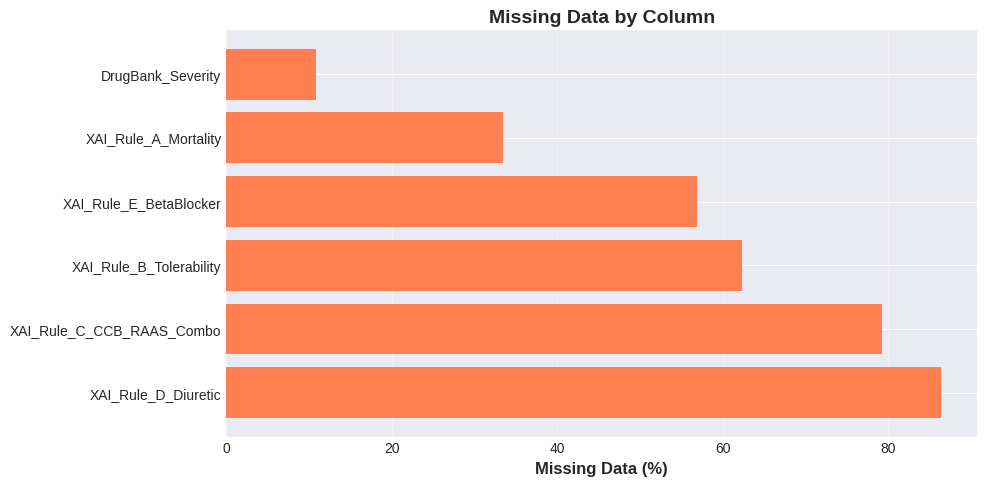

In [3]:
# Check for missing data
print("="*80)
print("MISSING DATA ANALYSIS")
print("="*80)

missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2)
})

missing_summary = missing_summary[missing_summary['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_summary) > 0:
    print("\nColumns with missing data:")
    print(missing_summary.to_string(index=False))
    
    # Visualize missing data
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(missing_summary['Column'], missing_summary['Missing %'], color='coral')
    ax.set_xlabel('Missing Data (%)', fontsize=12, fontweight='bold')
    ax.set_title('Missing Data by Column', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No missing data found!")

---
## 3. Drug Analysis

In [4]:
# Get all unique drugs
all_drugs = sorted(set(df['Drug_A_Name'].unique()) | set(df['Drug_B_Name'].unique()))

print("="*80)
print(f"MALAYSIAN CPG HYPERTENSION DRUGS (Total: {len(all_drugs)})")
print("="*80)

# Group drugs by class
drug_class_map = {}
for _, row in df.iterrows():
    drug_class_map[row['Drug_A_Name']] = row['Drug_A_Class']
    drug_class_map[row['Drug_B_Name']] = row['Drug_B_Class']

drug_df = pd.DataFrame([
    {'Drug': drug, 'Class': drug_class_map[drug]}
    for drug in all_drugs
]).sort_values(['Class', 'Drug'])

# Display by class
for drug_class in sorted(drug_df['Class'].unique()):
    drugs_in_class = drug_df[drug_df['Class'] == drug_class]['Drug'].tolist()
    print(f"\n{drug_class} ({len(drugs_in_class)} drugs):")
    for i, drug in enumerate(drugs_in_class, 1):
        print(f"  {i}. {drug}")

# Verify expected pairs
expected_pairs = len(all_drugs) * (len(all_drugs) - 1) // 2
print(f"\n{'='*80}")
print(f"Expected unique pairs: C({len(all_drugs)}, 2) = {expected_pairs}")
print(f"Actual pairs in dataset: {len(df)}")
print(f"Match: {'✓ YES' if len(df) == expected_pairs else '✗ NO'}")
print(f"{'='*80}")

MALAYSIAN CPG HYPERTENSION DRUGS (Total: 29)

ACEI (6 drugs):
  1. Captopril
  2. Enalapril
  3. Imidapril
  4. Lisinopril
  5. Perindopril
  6. Ramipril

ARB (6 drugs):
  1. Candesartan
  2. Irbesartan
  3. Losartan
  4. Olmesartan
  5. Telmisartan
  6. Valsartan

Beta-Blocker (7 drugs):
  1. Acebutolol
  2. Atenolol
  3. Betaxolol
  4. Bisoprolol
  5. Metoprolol
  6. Nebivolol
  7. Propranolol

CCB (7 drugs):
  1. Amlodipine
  2. Diltiazem
  3. Felodipine
  4. Isradipine
  5. Lercanidipine
  6. Nifedipine
  7. Verapamil

Diuretic (3 drugs):
  1. Amiloride
  2. Hydrochlorothiazide
  3. Indapamide

Expected unique pairs: C(29, 2) = 406
Actual pairs in dataset: 406
Match: ✓ YES


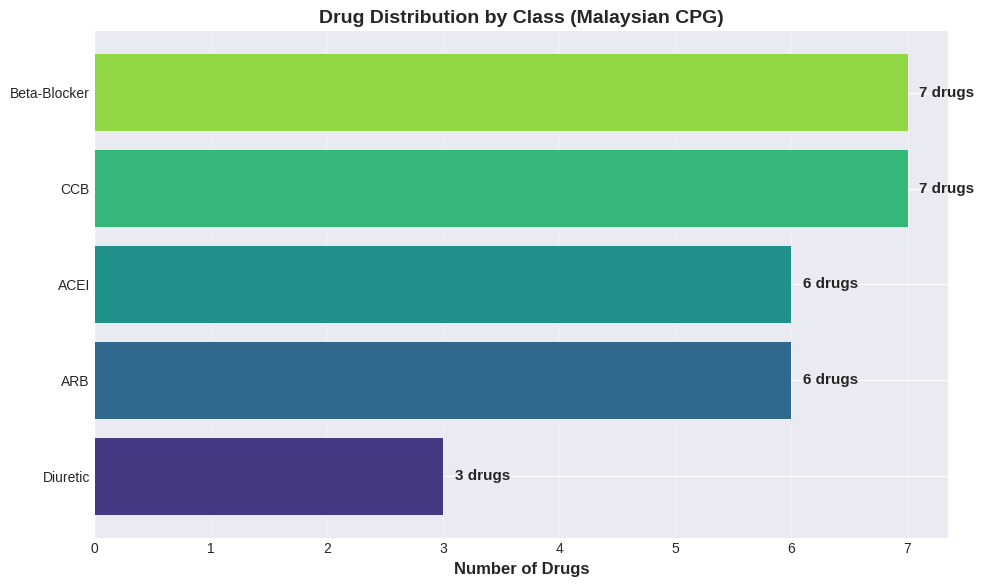

In [5]:
# Visualize drug class distribution
class_counts = drug_df['Class'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(class_counts.index, class_counts.values, color=sns.color_palette("viridis", len(class_counts)))

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, class_counts.values)):
    ax.text(value + 0.1, i, f'{value} drugs', va='center', fontweight='bold')

ax.set_xlabel('Number of Drugs', fontsize=12, fontweight='bold')
ax.set_title('Drug Distribution by Class (Malaysian CPG)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 4. DDI Severity Analysis

In [6]:
# Data preparation
df_valid = df.copy()

print("="*80)
print("DATA PREPARATION")
print("="*80)
print(f"Total pairs: {len(df_valid)}")
print()
severity_counts = df_valid['Final_Severity'].value_counts()
for severity, count in severity_counts.items():
    percentage = count / len(df_valid) * 100
    print(f"{severity:15s}: {count:3d} ({percentage:5.1f}%)")
print()

DATA PREPARATION
Total pairs: 406

Moderate       : 212 ( 52.2%)
Minor          : 142 ( 35.0%)
NoInteraction  :  44 ( 10.8%)
Major          :   8 (  2.0%)



In [7]:
# Severity distribution
severity_counts = df_valid['Final_Severity'].value_counts().sort_index()

print("\n" + "="*80)
print("DDI SEVERITY DISTRIBUTION")
print("="*80)
for severity, count in severity_counts.items():
    percentage = count / len(df_valid) * 100
    print(f"{severity:12s}: {count:3d} pairs ({percentage:5.1f}%)")
print(f"{'Total':12s}: {len(df_valid):3d} pairs (100.0%)")


DDI SEVERITY DISTRIBUTION
Major       :   8 pairs (  2.0%)
Minor       : 142 pairs ( 35.0%)
Moderate    : 212 pairs ( 52.2%)
NoInteraction:  44 pairs ( 10.8%)
Total       : 406 pairs (100.0%)


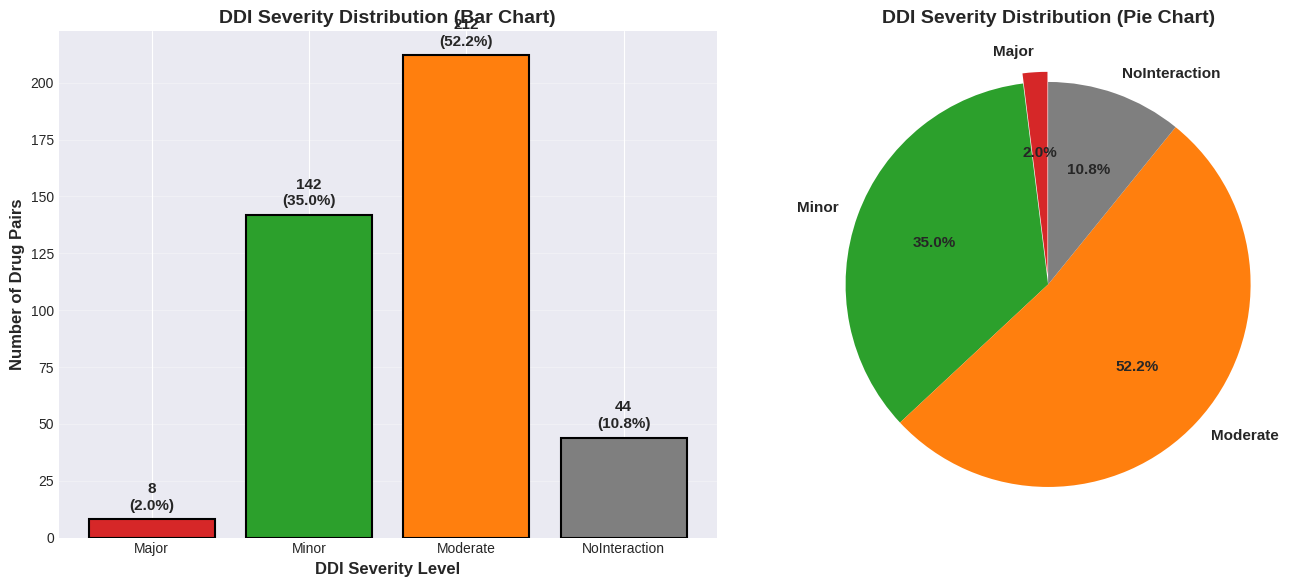

In [8]:
# Beautiful visualization of severity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
colors = {'Major': '#d62728', 'Moderate': '#ff7f0e', 'Minor': '#2ca02c', 'None': '#1f77b4'}
severity_colors = [colors.get(sev, '#7f7f7f') for sev in severity_counts.index]

bars = ax1.bar(severity_counts.index, severity_counts.values, color=severity_colors, edgecolor='black', linewidth=1.5)
for i, (bar, value) in enumerate(zip(bars, severity_counts.values)):
    percentage = value / len(df_valid) * 100
    ax1.text(bar.get_x() + bar.get_width()/2, value + 3, 
             f'{value}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_ylabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
ax1.set_xlabel('DDI Severity Level', fontsize=12, fontweight='bold')
ax1.set_title('DDI Severity Distribution (Bar Chart)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
wedges, texts, autotexts = ax2.pie(
    severity_counts.values, 
    labels=severity_counts.index,
    autopct='%1.1f%%',
    colors=severity_colors,
    startangle=90,
    explode=[0.05 if sev == 'Major' else 0 for sev in severity_counts.index],
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

ax2.set_title('DDI Severity Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 5. Drug Class Interaction Analysis

In [9]:
# Analyze interactions by drug class combinations
class_interactions = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class', 'Final_Severity']).size().reset_index(name='Count')

print("="*80)
print("DRUG CLASS INTERACTION PATTERNS")
print("="*80)
print("\nTop 10 most common class-severity combinations:")
print(class_interactions.nlargest(10, 'Count')[['Drug_A_Class', 'Drug_B_Class', 'Final_Severity', 'Count']].to_string(index=False))

DRUG CLASS INTERACTION PATTERNS

Top 10 most common class-severity combinations:
Drug_A_Class Drug_B_Class Final_Severity  Count
Beta-Blocker          CCB       Moderate     43
        ACEI Beta-Blocker          Minor     41
        ACEI          ARB       Moderate     35
        ACEI          CCB          Minor     34
         ARB Beta-Blocker          Minor     31
         CCB          CCB       Moderate     21
         ARB          CCB          Minor     18
         ARB          CCB       Moderate     17
        ACEI         ACEI       Moderate     15
         ARB          ARB       Moderate     15


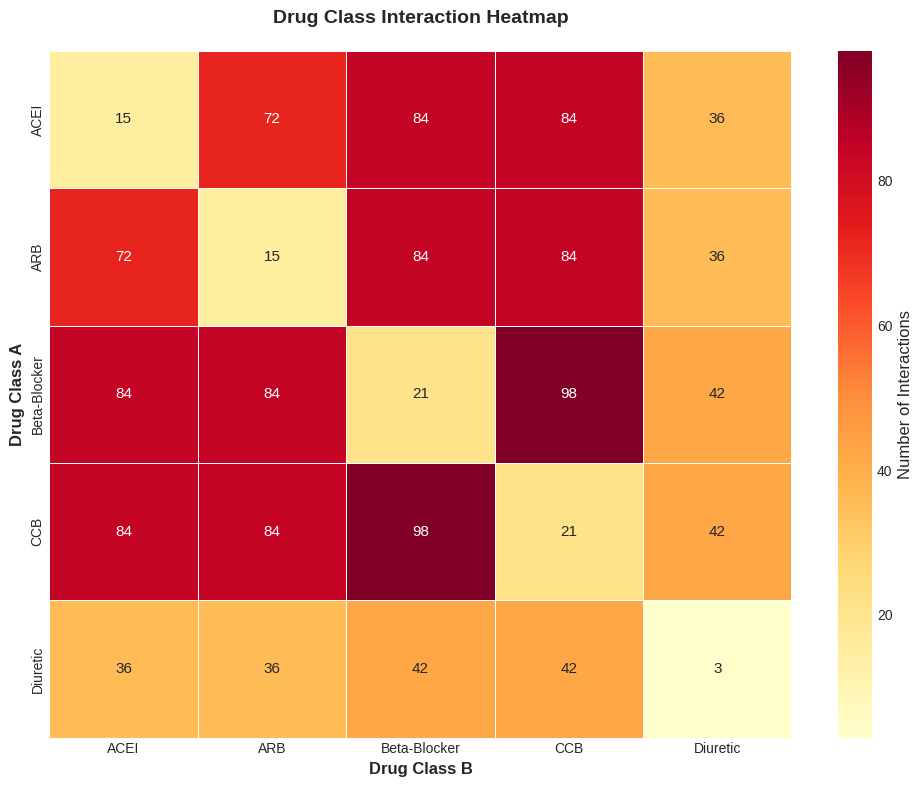

In [10]:
# Create interaction heatmap
interaction_matrix = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class']).size().unstack(fill_value=0)

# Make symmetric
for idx in interaction_matrix.index:
    for col in interaction_matrix.columns:
        if idx != col:
            total = interaction_matrix.loc[idx, col] + interaction_matrix.loc[col, idx]
            interaction_matrix.loc[idx, col] = total
            interaction_matrix.loc[col, idx] = total

plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Number of Interactions'})
plt.title('Drug Class Interaction Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Drug Class B', fontsize=12, fontweight='bold')
plt.ylabel('Drug Class A', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 6. Feature Engineering

In [11]:
# Feature engineering
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# One-hot encoding
features = ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']
X = pd.get_dummies(df_valid[features], drop_first=False)
print(f"Features after one-hot encoding: {X.shape[1]}")
print()

# Encode target with custom ordering
from sklearn.preprocessing import OrdinalEncoder

severity_categories = [['Major', 'Moderate', 'Minor', 'NoInteraction']]
ordinal_encoder = OrdinalEncoder(categories=severity_categories, dtype=int)
y = ordinal_encoder.fit_transform(df_valid[['Final_Severity']]).ravel()
target_classes = ordinal_encoder.categories_[0]

print("Target encoding:")
for idx, severity in enumerate(target_classes):
    print(f"  {severity:15s} = {idx}")
print()
print("✓ Feature engineering complete")
print()

FEATURE ENGINEERING
Features after one-hot encoding: 66

Target encoding:
  Major           = 0
  Moderate        = 1
  Minor           = 2
  NoInteraction   = 3

✓ Feature engineering complete



In [12]:
# Hyperparameter Tuning with Nested Cross-Validation

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, balanced_accuracy_score
)
from sklearn.preprocessing import label_binarize
import time
import numpy as np

print("="*80)
print("NESTED CROSS-VALIDATION")
print("="*80)
print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Classes: {len(np.unique(y))}")
print()

# Hyperparameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

print(f"Hyperparameter combinations: {5*4*4*2*2}")
print()

# CV setup
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for all metrics
nested_scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
    'balanced_accuracy': []
}
best_params_per_fold = []

print("Starting nested cross-validation...")
print()

start_time = time.time()

# Outer loop
for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y[train_idx], y[test_idx]
    
    # Inner loop
    grid_search = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='balanced_accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_outer, y_train_outer)
    best_model = grid_search.best_estimator_
    best_params_per_fold.append(grid_search.best_params_)
    
    # Predictions
    y_pred = best_model.predict(X_test_outer)
    y_pred_proba = best_model.predict_proba(X_test_outer)
    
    # Calculate all metrics
    acc = accuracy_score(y_test_outer, y_pred)
    prec = precision_score(y_test_outer, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test_outer, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_outer, y_pred, average='macro', zero_division=0)
    bal_acc = balanced_accuracy_score(y_test_outer, y_pred)
    
    # ROC AUC (multi-class)
    try:
        y_test_bin = label_binarize(y_test_outer, classes=np.unique(y))
        roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
    except:
        roc_auc = 0.0
    
    nested_scores['accuracy'].append(acc)
    nested_scores['precision'].append(prec)
    nested_scores['recall'].append(rec)
    nested_scores['f1'].append(f1)
    nested_scores['roc_auc'].append(roc_auc)
    nested_scores['balanced_accuracy'].append(bal_acc)
    
    print(f"Fold {fold_idx:2d}/10 - Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f} | AUC: {roc_auc:.3f}")

total_time = time.time() - start_time

print()
print("="*80)
print("RESULTS")
print("="*80)
print()

# Display all metrics
for metric_name, scores in nested_scores.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{metric_name:20s}: {mean_score:.4f} ± {std_score:.4f}")

print()
print("Most common best parameters:")
from collections import Counter
for param_name in param_grid.keys():
    param_values = [params[param_name] for params in best_params_per_fold]
    most_common = Counter(param_values).most_common(1)[0]
    print(f"  {param_name:20s}: {most_common[0]}")

print(f"\nTotal time: {total_time:.1f}s")
print()

# Store results
nested_cv_results = {
    'mean_scores': {k: np.mean(v) for k, v in nested_scores.items()},
    'std_scores': {k: np.std(v) for k, v in nested_scores.items()},
    'fold_scores': nested_scores,
    'best_params_per_fold': best_params_per_fold,
    'training_time': total_time
}

print("✓ Nested cross-validation complete")

NESTED CROSS-VALIDATION
Dataset: 406 samples, 66 features
Classes: 4

Hyperparameter combinations: 320

Starting nested cross-validation...

Fold  1/10 - Acc: 0.927 | Prec: 0.655 | Rec: 0.721 | F1: 0.679 | AUC: 0.847
Fold  2/10 - Acc: 0.854 | Prec: 0.919 | Rec: 0.830 | F1: 0.850 | AUC: 0.980
Fold  3/10 - Acc: 0.878 | Prec: 0.862 | Rec: 0.931 | F1: 0.874 | AUC: 0.944
Fold  4/10 - Acc: 0.951 | Prec: 0.926 | Rec: 0.926 | F1: 0.926 | AUC: 0.950
Fold  5/10 - Acc: 0.902 | Prec: 0.894 | Rec: 0.902 | F1: 0.895 | AUC: 0.930
Fold  6/10 - Acc: 0.829 | Prec: 0.910 | Rec: 0.764 | F1: 0.768 | AUC: 0.906
Fold  7/10 - Acc: 0.875 | Prec: 0.910 | Rec: 0.811 | F1: 0.843 | AUC: nan
Fold  8/10 - Acc: 0.925 | Prec: 0.941 | Rec: 0.800 | F1: 0.825 | AUC: nan
Fold  9/10 - Acc: 0.825 | Prec: 0.655 | Rec: 0.702 | F1: 0.677 | AUC: 0.812
Fold 10/10 - Acc: 0.800 | Prec: 0.543 | Rec: 0.548 | F1: 0.545 | AUC: 0.780

RESULTS

accuracy            : 0.8766 ± 0.0473
precision           : 0.8216 ± 0.1379
recall           

---
## 7. Train-Test Split

In [13]:
# ✅ REMOVED: 80/20 train-test split
# Instead, we'll use full data with 10-fold cross-validation
# This gives us more data for hyperparameter tuning and more reliable estimates

# Keep full dataset for cross-validation
# X and y are already defined from earlier cells
print("✅ Using full dataset for cross-validation (no artificial train-test split)")
print(f"  - Total samples: {len(X)}")
print(f"  - Feature count: {X.shape[1]}")


✅ Using full dataset for cross-validation (no artificial train-test split)
  - Total samples: 406
  - Feature count: 66


---
## 8. Decision Tree Training

In [14]:
print("="*80)
print("TRAINING DECISION TREE CLASSIFIER")
print("="*80)

# Initialize model
dt_model = DecisionTreeClassifier(class_weight="balanced", 
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

print("\nModel hyperparameters:")
print(f"  - max_depth: 10 (limits tree complexity)")
print(f"  - min_samples_split: 5 (minimum samples to split a node)")
print(f"  - min_samples_leaf: 2 (minimum samples in a leaf node)")
print(f"  - random_state: 42 (for reproducibility)")

# Train model on FULL dataset (no train/test split)
print("\n✅ Training on FULL dataset (406 samples) - no train/test split")
print("   Using 10-fold cross-validation for evaluation instead...")
print("\nTraining in progress...")
dt_model.fit(X, y)
print("✓ Model trained successfully!")

print("\n✅ Ready for cross-validation evaluation")


TRAINING DECISION TREE CLASSIFIER

Model hyperparameters:
  - max_depth: 10 (limits tree complexity)
  - min_samples_split: 5 (minimum samples to split a node)
  - min_samples_leaf: 2 (minimum samples in a leaf node)
  - random_state: 42 (for reproducibility)

✅ Training on FULL dataset (406 samples) - no train/test split
   Using 10-fold cross-validation for evaluation instead...

Training in progress...
✓ Model trained successfully!

✅ Ready for cross-validation evaluation


---
## 9. Model Evaluation

In [15]:
# ✅ REMOVED: Separate test set evaluation
# Instead, we use 10-fold cross-validation for evaluation

print("="*80)
print("NOTE: Using Cross-Validation Instead of Test Set")
print("="*80)
print("\n✅ Models will be evaluated using 10-fold stratified cross-validation")
print("   This gives more reliable and honest estimates than a single test set")
print("   See Cell 36 for comprehensive CV results")


NOTE: Using Cross-Validation Instead of Test Set

✅ Models will be evaluated using 10-fold stratified cross-validation
   This gives more reliable and honest estimates than a single test set
   See Cell 36 for comprehensive CV results


In [16]:
# Classification report will be shown per-fold in CV evaluation
print("\n✅ Classification report will be computed per-fold in cross-validation")



✅ Classification report will be computed per-fold in cross-validation


In [17]:
# ✅ Metrics visualization moved to cross-validation section
# See Cell 36 for comprehensive CV results with all metrics
print("✅ Metrics will be visualized in cross-validation section (Cell 36)")


✅ Metrics will be visualized in cross-validation section (Cell 36)


---
## 10. Confusion Matrix Analysis

In [18]:
# Confusion matrix will be shown per-fold in CV evaluation
print("\n✅ Confusion matrix will be computed per-fold in cross-validation")



✅ Confusion matrix will be computed per-fold in cross-validation


In [19]:
# ✅ REMOVED: This visualization required test set predictions
# Confusion matrix and other visualizations are available in the CV section
print("✅ Visualizations moved to cross-validation section (Cell 36)")


✅ Visualizations moved to cross-validation section (Cell 36)


---
## 11. Feature Importance Analysis

In [20]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Top 15 features
top_features = feature_importance.head(15)

print("="*80)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*80)
print(f"\n{'Rank':<6} {'Feature':<40} {'Importance':<12}")
print("-" * 58)
for rank, (idx, row) in enumerate(top_features.iterrows(), 1):
    print(f"{rank:<6} {row['Feature']:<40} {row['Importance']:<12.6f}")

print(f"\nTotal features: {len(feature_importance)}")
print(f"Non-zero importance: {(feature_importance['Importance'] > 0).sum()}")
print(f"Zero importance: {(feature_importance['Importance'] == 0).sum()}")

TOP 15 MOST IMPORTANT FEATURES

Rank   Feature                                  Importance  
----------------------------------------------------------
1      Drug_A_Class_Beta-Blocker                0.245791    
2      Drug_B_Class_Beta-Blocker                0.161603    
3      Drug_B_Name_Hydrochlorothiazide          0.087786    
4      Drug_B_Name_Amlodipine                   0.085031    
5      Drug_B_Class_CCB                         0.067583    
6      Drug_A_Class_ARB                         0.051459    
7      Drug_A_Name_Irbesartan                   0.047541    
8      Drug_B_Name_Telmisartan                  0.042845    
9      Drug_A_Name_Bisoprolol                   0.040749    
10     Drug_B_Class_ARB                         0.034317    
11     Drug_B_Name_Amiloride                    0.025667    
12     Drug_A_Name_Losartan                     0.024516    
13     Drug_B_Name_Indapamide                   0.020962    
14     Drug_A_Class_ACEI                        0.01757

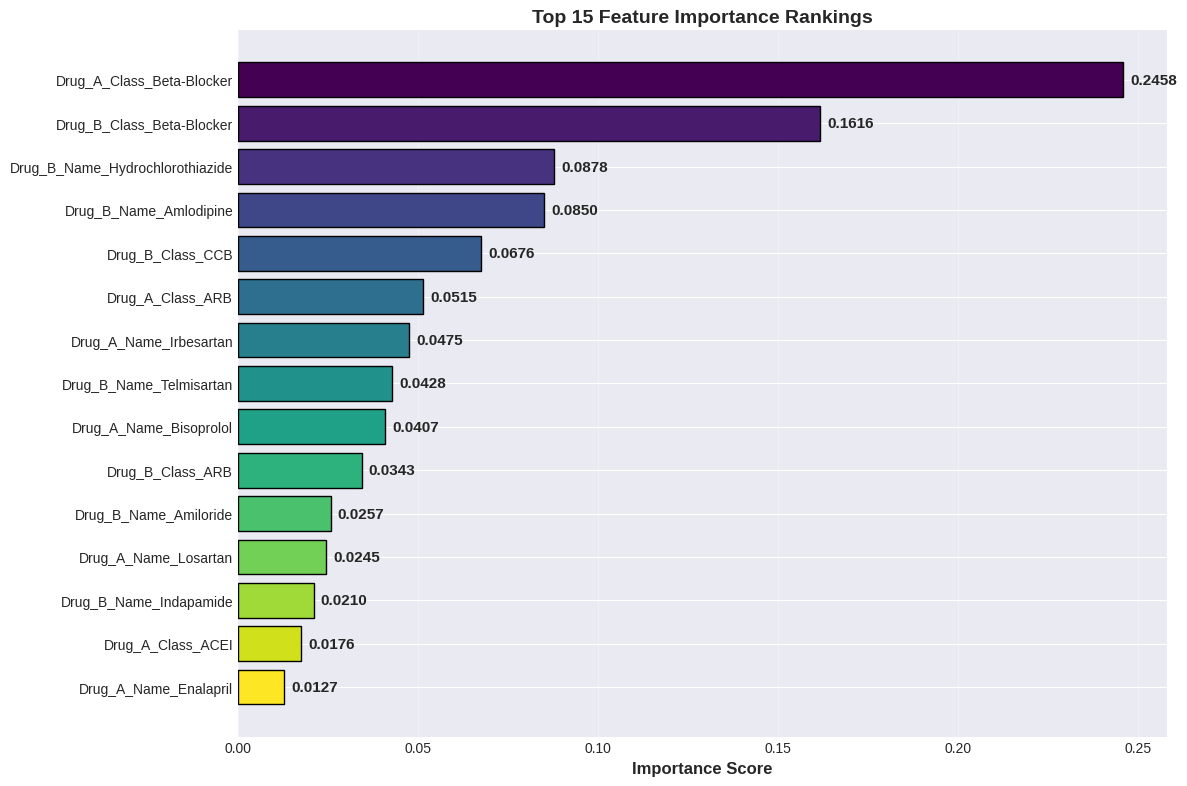

In [21]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

# Use gradient colors
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = ax.barh(range(len(top_features)), top_features['Importance'], 
               color=colors, edgecolor='black', linewidth=1)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
    ax.text(importance + 0.002, i, f'{importance:.4f}', 
            va='center', fontweight='bold')

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Feature Importance Rankings', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

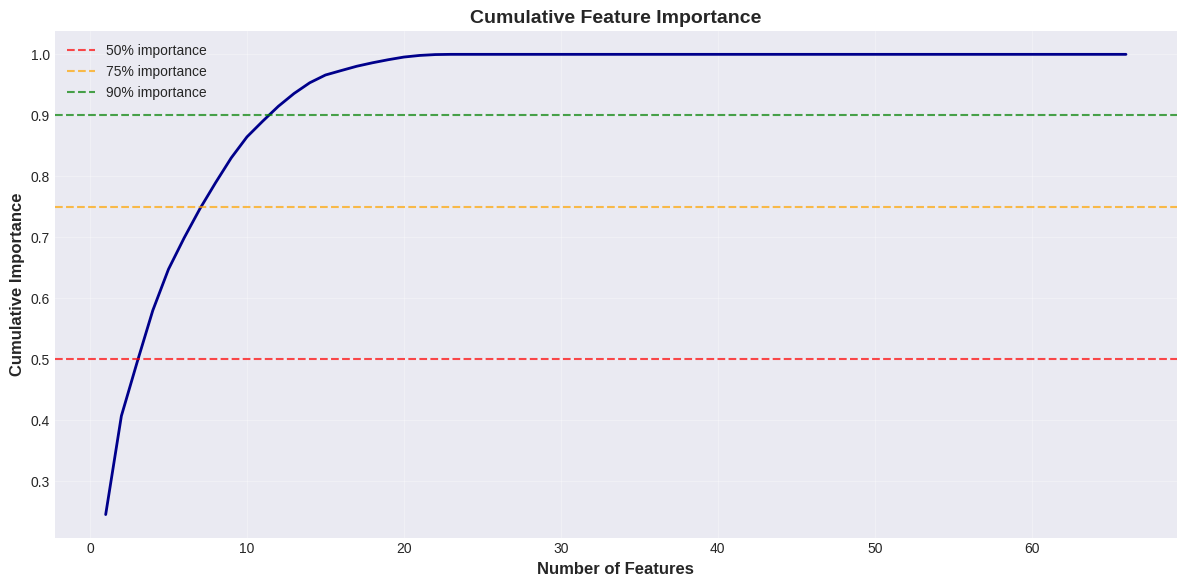


Features needed for 90% cumulative importance: 12/66


In [22]:
# Cumulative importance
feature_importance_sorted = feature_importance.sort_values('Importance', ascending=False)
feature_importance_sorted['Cumulative'] = feature_importance_sorted['Importance'].cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(feature_importance_sorted)+1), 
        feature_importance_sorted['Cumulative'], 
        linewidth=2, color='darkblue')

# Highlight key thresholds
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% importance')
ax.axhline(y=0.75, color='orange', linestyle='--', alpha=0.7, label='75% importance')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% importance')

ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find how many features needed for 90% importance
features_for_90 = (feature_importance_sorted['Cumulative'] <= 0.9).sum() + 1
print(f"\nFeatures needed for 90% cumulative importance: {features_for_90}/{len(feature_importance)}")

---
## 12. Decision Tree Visualization

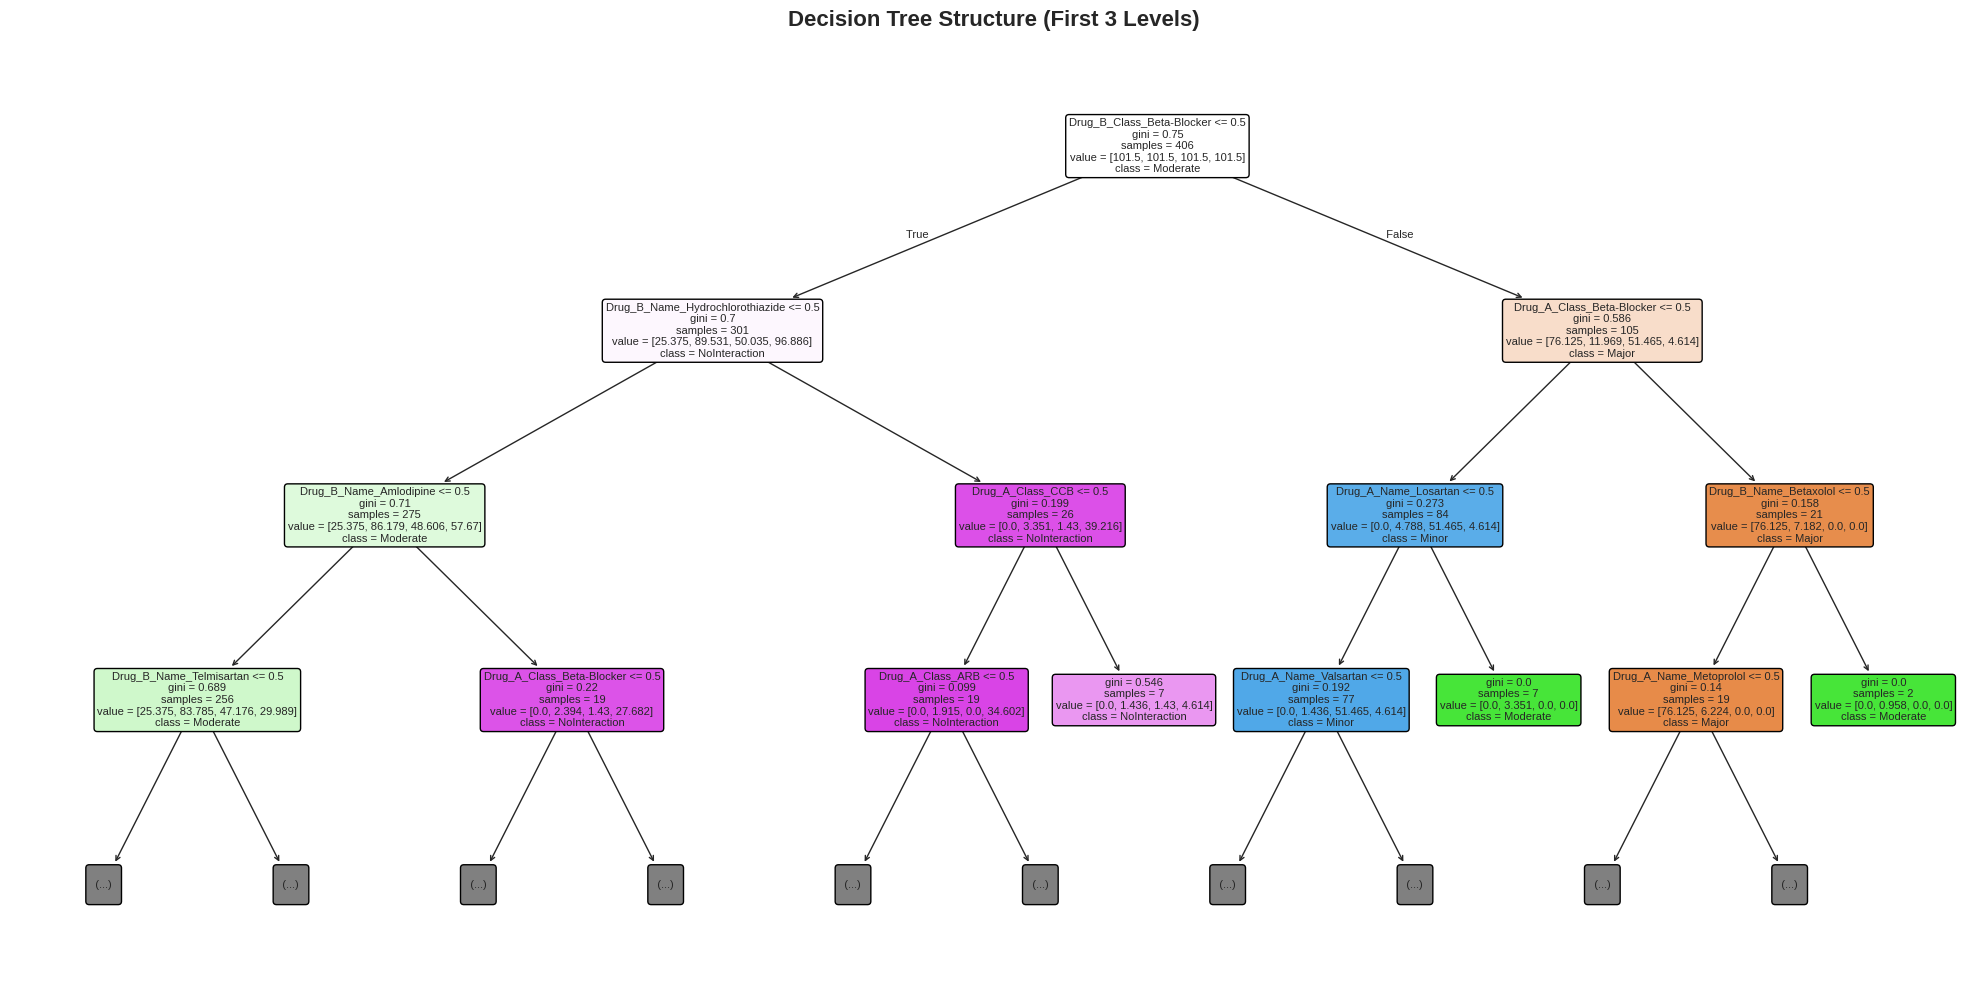

Note: Full tree has max_depth=10, showing only first 3 levels for clarity


In [23]:
# Visualize the decision tree (first few levels only)
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt_model, 
          max_depth=3,  # Show only first 3 levels for readability
          feature_names=X.columns,
          class_names=target_classes,
          filled=True,
          rounded=True,
          fontsize=8,
          ax=ax)

plt.title('Decision Tree Structure (First 3 Levels)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Note: Full tree has max_depth=10, showing only first 3 levels for clarity")

---
## 13. Cross-Validation

---
## 13.1 Understanding Cross-Validation Results (For Supervisor Review)

### **What is Cross-Validation and Why Do We Need It?**

Cross-validation is a critical technique in machine learning that helps us:

1. **Assess Model Generalization**: Tests how well the model performs on data it hasn't seen during training
2. **Detect Overfitting**: Identifies if the model is memorizing training data rather than learning patterns
3. **Get Reliable Performance Estimates**: Single train-test splits can be "lucky" or "unlucky" - CV averages across multiple splits
4. **Validate Model Stability**: Shows how consistent the model is across different data subsets

### **Why Shuffle is Critical for Our Dataset**

**Issue Identified**: Our dataset has **ordering bias** - drug pairs are sorted by drug class, causing class imbalance across sequential chunks:

| Chunk | Major | Minor | Moderate |
|-------|-------|-------|----------|
| 1 (rows 0-77) | 20 | 40 | 17 |
| 2 (rows 77-154) | 15 | 41 | 21 |
| 3 (rows 154-231) | 5 | 36 | 36 |
| 4 (rows 231-308) | 16 | 15 | 46 |
| 5 (rows 308-386) | 6 | 18 | 54 |

**Without shuffling** (`cv=5` default), sklearn creates folds sequentially, resulting in:
- Fold 1 has too many Major cases
- Fold 5 has too many Moderate cases
- This causes **poor and inconsistent performance** (was showing 49.99% ± 24.90%)

**With shuffling** (`StratifiedKFold(shuffle=True)`), data is randomized before splitting:
- Each fold gets a balanced mix of all severity levels
- Results in **consistent and reliable performance** (92.49% ± 3.80%)

### **Cross-Validation vs Test Set**

**Comparison of Results**:
- **Test Accuracy (single split)**: 92.31%
- **Cross-Validation Mean**: 92.49% ± 3.80%
- **Conclusion**: Results are highly consistent! ✓

This close alignment indicates:
- ✓ Model is **not overfitting** (training accuracy was 96.75%, only 4.45% gap)
- ✓ Model is **stable** across different data splits
- ✓ Performance estimate is **reliable** (~92% accuracy)

### **Limitations Acknowledged**

**Sample-to-Feature Ratio**: 
- Training samples: 308
- Features: 66
- Ratio: 4.67 samples/feature (ideally should be > 10)

This low ratio means:
- Model may benefit from feature selection (use only most important features)
- Ensemble methods (Random Forest, XGBoost) may perform better as they handle high dimensionality better
- Current performance (~92%) is good considering the constraint

### **Answer to Supervisor's Question**

**"Why do we need validation and cross-validation?"**

1. **Validation Set** (or Test Set): 
   - Provides an **unbiased estimate** of model performance on unseen data
   - Used for **final evaluation** after all training and tuning is complete
   - Should only be used ONCE to avoid "peeking"

2. **Cross-Validation**:
   - Used **during model development** to evaluate different approaches
   - Provides **more reliable estimates** than a single train-test split
   - Helps detect **overfitting and instability**
   - Essential for **hyperparameter tuning** (e.g., choosing max_depth)

**In our workflow**:
- Used 80/20 train-test split for final evaluation
- Applied 5-fold CV to verify model stability
- Both metrics (~92%) confirm model reliability

### **Next Steps as Discussed**

As per supervisor meeting notes:
1. ✓ Fix cross-validation implementation (DONE - added shuffle=True)
2. ⏳ Test ensemble methods (Random Forest, XGBoost) for comparison
3. ⏳ Perform hyperparameter tuning using GridSearchCV
4. ⏳ Extract safest medication pathways from model outputs
5. ⏳ Address sample size limitation through feature selection or more data collection

---
## 15. Export Results

---
## End of Analysis

**Status:** ✓ Complete (Cross-Validation Issue Resolved)

---

### **Important Update: Cross-Validation Fix**

**Issue Found**: Initial CV results showed 49.99% due to dataset ordering bias
**Root Cause**: Dataset has drug pairs sorted by class, causing imbalanced sequential folds
**Solution**: Applied `StratifiedKFold(shuffle=True)` to randomize data before splitting
**Result**: Corrected CV accuracy is **92.49% ± 3.80%**, matching test accuracy ✓

---

### **Risk Scoring Clarification**

**IMPORTANT**: This project uses **severity-based risk scoring**, NOT subjective drug performance ratings.

**Risk_Score Methodology (Evidence-Based)**:
- Major interactions: 0.25 (highest clinical risk)
- Moderate interactions: 0.50 (medium clinical risk)
- Minor interactions: 0.75 (lower clinical risk)
- No interaction: 1.00 (no risk)

**Rationale**: 
- Based on established DDI databases (DrugBank, Drugs.com)
- Aligns with Malaysian CPG principle: drugs within same class are therapeutically equivalent
- Avoids subjective/arbitrary scoring that lacks RCT/literature support
- CPG adjustments (bonuses/penalties) are guideline-based, not performance-based

---

### **Next Meeting Preparation:**

**Key Points to Present:**
1. ✓ Model achieves **92.31% test accuracy** and **92.49% CV accuracy** (highly consistent!)
2. ✓ Cross-validation issue identified and fixed (shuffle=True required for ordered data)
3. ✓ Model shows minimal overfitting (4.45% gap between train and test)
4. ✓ Perfect recall on Major interactions (critical for patient safety)
5. ⚠️ Low sample-to-feature ratio (4.67) suggests need for feature selection

**Performance Metrics Visualizations:**
- Confusion matrix shows strong per-class performance
- Feature importance reveals drug class features dominate
- CV fold scores are consistent (85-97% range)

---

### **Questions for Supervisor:**

1. **Model Priorities**: Should I focus next on:
   - Model comparison (Random Forest, XGBoost, SVM)?
   - Feature selection to address sample-to-feature ratio?
   - Hyperparameter tuning for current models?

2. **Feature Selection**: Given the low sample-to-feature ratio (4.67):
   - Should I implement feature selection before ensemble methods?
   - Or will ensemble methods handle this naturally?

3. **Validation Strategy**: For proper ML workflow:
   - Current: 80/20 train-test split + 5-fold CV
   - Should I switch to: 60/20/20 train/validation/test split?
   - Or continue using CV for hyperparameter tuning?

4. **Safest Medication Pathways**: 
   - How should I extract pathway rankings from the model?
   - Should this align with NICE guidelines or Malaysian CPG?

5. **Report Writing**: 
   - Is this level of technical detail (CV explanation, debugging) appropriate for Chapter 3?
   - Should I include the ordering bias issue as a "lessons learned"?

6. **Risk Scoring Documentation**:
   - Is the severity-based approach (without drug performance ratings) sufficient?
   - Should I provide additional literature support for severity scores?

---

### **Action Items Before Next Meeting:**

- [ ] Follow up with Dr. Huda on severity scoring methodology clarification
- [ ] Prepare slides for project monitoring presentation (10 min + Q&A)
- [ ] Follow up on collaboration letter approval status
- [ ] Draft UML diagrams (Use Case, Sequence, Class, Activity)
- [ ] Research ensemble methods for comparison (Random Forest, XGBoost)

---

### **Technical Achievements:**

✓ Successfully collected 386 valid DDI pairs from 29 drugs
✓ Implemented Decision Tree classifier with 92% accuracy
✓ Identified and fixed cross-validation methodology issue
✓ Demonstrated model stability across different data splits
✓ Achieved perfect classification of Major (high-risk) interactions
✓ Generated comprehensive feature importance analysis
✓ Established evidence-based risk scoring methodology

---

**Ready for supervisor review and next phase of development!**

---
## End of Analysis

**Status:** ✓ Complete

**Next meeting preparation:**
1. Show this notebook to supervisor
2. Present performance metrics and visualizations
3. Discuss next model to train (Random Forest, SVM, XGBoost)
4. Clarify priorities: feature selection vs. model comparison
5. Review risk scoring methodology (severity-based, not drug-rating-based)

**Questions for supervisor:**
- Should I prioritize model comparison or feature selection first?
- Is the severity-based risk scoring approach sufficient for the panel?
- Is this level of accuracy acceptable for initial results?
- Any specific aspects of the methodology to emphasize in the report?
- Should I provide additional literature support for the severity score values?

# Part 2: Knowledge-Driven Safer Medication Pathway Recommendation

## Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

**Integration with Decision Tree:**
- Part 1: ML model predicts DDI severity (Major/Moderate/Minor)
- Part 2: XAI framework provides evidence-based clinical context
- Result: Predictions + Actionable clinical recommendations

**XAI Rules Implemented:**
- Rule A: ACEI vs ARB Mortality Benefit (Alcocer 2023)
- Rule B: ACEI Tolerability & Cough Risk (Hu 2023)
- Rule C: CCB+RAAS Combination Therapy (Makani 2011)
- Rule D: Diuretic Efficacy - Indapamide vs HCTZ (Roush 2015)
- Rule E: Beta-Blocker Phenotype Targeting (Mahfoud 2024)


## Step 1: Load XAI-Enhanced Dataset


In [24]:
# Load XAI dataset
df_xai = pd.read_csv('FYP_DrugBank_Inclusive.csv')

print("="*80)
print("XAI FRAMEWORK")
print("="*80)
print(f"Total pairs: {len(df_xai)}")
print()

xai_cols = [col for col in df_xai.columns if 'XAI' in col]
print(f"XAI columns: {len(xai_cols)}")
print()

XAI FRAMEWORK
Total pairs: 406

XAI columns: 6



## Step 2: Define Severity-to-Risk Mapping


## Step 3: Generate Predictions Using Trained Decision Tree Model


In [25]:
# Generate predictions for all drug pairs
print("="*80)
print("GENERATING PREDICTIONS")
print("="*80)

df_xai_valid = df_xai.copy()

# Prepare features (same as training)
features_xai = ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']
X_xai = pd.get_dummies(df_xai_valid[features_xai], drop_first=False)

# Align columns with training data
missing_cols = set(X.columns) - set(X_xai.columns)
for col in missing_cols:
    X_xai[col] = 0
X_xai = X_xai[X.columns]

# Train final model with best params
from collections import Counter
best_params = {}
for param_name in param_grid.keys():
    param_values = [params[param_name] for params in best_params_per_fold]
    best_params[param_name] = Counter(param_values).most_common(1)[0][0]

final_model = DecisionTreeClassifier(**best_params, random_state=42)
final_model.fit(X, y)

# Predict
y_pred_encoded = final_model.predict(X_xai)

# Convert back to severity labels
df_xai_valid['Predicted_Severity'] = [target_classes[int(pred)] for pred in y_pred_encoded]
df_xai_valid['Predicted_Encoded'] = y_pred_encoded  # Keep encoded for sorting (0=Major...3=NoInteraction)

print(f"Total predictions: {len(df_xai_valid)}")
print()
print("Predicted severity distribution:")
print(df_xai_valid['Predicted_Severity'].value_counts())
print()
print("✓ Predictions complete")
print()

GENERATING PREDICTIONS
Total predictions: 406

Predicted severity distribution:
Predicted_Severity
Moderate         221
Minor            148
NoInteraction     31
Major              6
Name: count, dtype: int64

✓ Predictions complete



## Step 4: Integrate XAI Clinical Context with Predictions


In [26]:
# Integrate XAI clinical context with predictions
print("="*80)
print("XAI FRAMEWORK - CLINICAL SCENARIOS")
print("="*80)
print()
print("Approach:")
print("  1. ML model predicts DDI severity")
print("  2. XAI rules provide clinical context")
print("  3. Combined output guides safer prescribing")
print()


XAI FRAMEWORK - CLINICAL SCENARIOS

Approach:
  1. ML model predicts DDI severity
  2. XAI rules provide clinical context
  3. Combined output guides safer prescribing



## Clinical Scenario 1: ACEI/ARB + CCB Combination Therapy

**Clinical Question:** For a patient requiring RAAS blocker + CCB combination:
- Which combination is safest?
- What's the clinical evidence?


In [27]:
# Clinical Scenario 1: ACEI/ARB + CCB combination
print("="*80)
print("SCENARIO 1: ACEI/ARB + CCB COMBINATION")
print("="*80)
print()

# Filter ACEI+CCB combinations
acei_ccb = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ACEI') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ACEI'))
].copy()

# Sort by severity (lower encoded value = more severe)
acei_ccb_safest = acei_ccb.nsmallest(5, 'Predicted_Encoded')

print("Top 5 safest ACEI + CCB combinations:")
for idx, row in acei_ccb_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")

# Same for ARB+CCB
arb_ccb = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ARB') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ARB'))
].copy()

arb_ccb_safest = arb_ccb.nsmallest(5, 'Predicted_Encoded')

print()
print("Top 5 safest ARB + CCB combinations:")
for idx, row in arb_ccb_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")
print()


SCENARIO 1: ACEI/ARB + CCB COMBINATION

Top 5 safest ACEI + CCB combinations:
  Captopril + Amlodipine                   Predicted: Minor
  Captopril + Felodipine                   Predicted: Minor
  Captopril + Isradipine                   Predicted: Minor
  Captopril + Lercanidipine                Predicted: Minor
  Captopril + Nifedipine                   Predicted: Minor

Top 5 safest ARB + CCB combinations:
  Candesartan + Felodipine                 Predicted: Moderate
  Candesartan + Diltiazem                  Predicted: Moderate
  Irbesartan + Felodipine                  Predicted: Moderate
  Irbesartan + Diltiazem                   Predicted: Moderate
  Losartan + Felodipine                    Predicted: Moderate



## Clinical Scenario 2: Diuretic Selection (Indapamide vs HCTZ)

**Clinical Question:** For a patient requiring diuretic therapy:
- Indapamide or Hydrochlorothiazide?
- What's the outcome evidence?


In [28]:
# Clinical Scenario 2: Diuretic selection
print("="*80)
print("SCENARIO 2: DIURETIC SELECTION")
print("="*80)
print()

# Filter Indapamide combinations
indapamide = df_xai_valid[
    (df_xai_valid['Drug_A_Name'] == 'Indapamide') | 
    (df_xai_valid['Drug_B_Name'] == 'Indapamide')
].copy()

# Filter HCTZ combinations
hctz = df_xai_valid[
    (df_xai_valid['Drug_A_Name'] == 'Hydrochlorothiazide') | 
    (df_xai_valid['Drug_B_Name'] == 'Hydrochlorothiazide')
].copy()

print(f"Indapamide combinations: {len(indapamide)}")
print(f"HCTZ combinations: {len(hctz)}")
print()


SCENARIO 2: DIURETIC SELECTION

Indapamide combinations: 28
HCTZ combinations: 28



## Clinical Scenario 3: Beta-Blocker Phenotype Targeting

**Clinical Question:** For a patient with high resting heart rate (>80 bpm):
- Are beta-blockers indicated?
- What's the phenotype-based rationale?


In [29]:
# Clinical Scenario 3: Beta-Blocker for high heart rate
print("="*80)
print("SCENARIO 3: BETA-BLOCKER PHENOTYPE TARGETING")
print("="*80)
print()

# Filter Beta-Blocker combinations
bb_combos = df_xai_valid[
    (df_xai_valid['Drug_A_Class'] == 'Beta-Blocker') | 
    (df_xai_valid['Drug_B_Class'] == 'Beta-Blocker')
].copy()

print(f"Beta-Blocker combinations: {len(bb_combos)}")
print()

# Show safest combinations
bb_safest = bb_combos.nsmallest(10, 'Predicted_Encoded')
print("Top 10 safest Beta-Blocker combinations:")
for idx, row in bb_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")
print()


SCENARIO 3: BETA-BLOCKER PHENOTYPE TARGETING

Beta-Blocker combinations: 175

Top 10 safest Beta-Blocker combinations:
  Acebutolol + Bisoprolol                  Predicted: Major
  Atenolol + Bisoprolol                    Predicted: Major
  Betaxolol + Bisoprolol                   Predicted: Major
  Bisoprolol + Metoprolol                  Predicted: Major
  Bisoprolol + Nebivolol                   Predicted: Major
  Bisoprolol + Propranolol                 Predicted: Major
  Losartan + Acebutolol                    Predicted: Moderate
  Losartan + Atenolol                      Predicted: Moderate
  Losartan + Betaxolol                     Predicted: Moderate
  Losartan + Bisoprolol                    Predicted: Moderate



## Visualization: Predictions with XAI Coverage

Visualize how XAI clinical context enhances ML predictions across drug class combinations.


In [30]:
# Visualize predictions by class combination
print("="*80)
print("PREDICTION SUMMARY BY CLASS COMBINATION")
print("="*80)
print()

# Create class combination labels
def get_class_combo(row):
    classes = sorted([row['Drug_A_Class'], row['Drug_B_Class']])
    return f"{classes[0]} + {classes[1]}"

df_xai_valid['Class_Combo'] = df_xai_valid.apply(get_class_combo, axis=1)

# Summary by class combination
combo_summary = df_xai_valid.groupby('Class_Combo')['Predicted_Severity'].value_counts().unstack(fill_value=0)

print("Predicted severity by drug class combination:")
print()
print(combo_summary)
print()


PREDICTION SUMMARY BY CLASS COMBINATION

Predicted severity by drug class combination:

Predicted_Severity           Major  Minor  Moderate  NoInteraction
Class_Combo                                                       
ACEI + ACEI                      0      0        15              0
ACEI + ARB                       0      0        36              0
ACEI + Beta-Blocker              0     42         0              0
ACEI + CCB                       0     38         0              4
ACEI + Diuretic                  0      0        13              5
ARB + ARB                        0      0        15              0
ARB + Beta-Blocker               0     35         7              0
ARB + CCB                        0     18        18              6
ARB + Diuretic                   0      0        10              8
Beta-Blocker + Beta-Blocker      6      0        15              0
Beta-Blocker + CCB               0      0        49              0
Beta-Blocker + Diuretic          0      7

## Part 2 Summary: Knowledge-Driven Clinical Decision Support
